In [4]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the path to the booktests directory is included (robust finder)
def _find_repo_root(start=os.getcwd()):
    cur = start
    while True:
        if os.path.exists(os.path.join(cur, 'pyproject.toml')):
            return cur
        parent = os.path.dirname(cur)
        if parent == cur:
            raise FileNotFoundError('repo root not found')
        cur = parent

sys.path.append(os.path.join(_find_repo_root(), 'test', 'booktests'))

# Configuration flags
force_compute = True
is_debug = False

# Create output directory if it doesn't exist
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

Longest sequential notebook: tb_joss2025 (386.16 s)
   workers   times  speedup
0        1  442.65     1.65
1        2  441.11     1.66
2        4  439.49     1.66
3        8  437.10     1.67
Saved plot to output/parallel_times_speedup.png


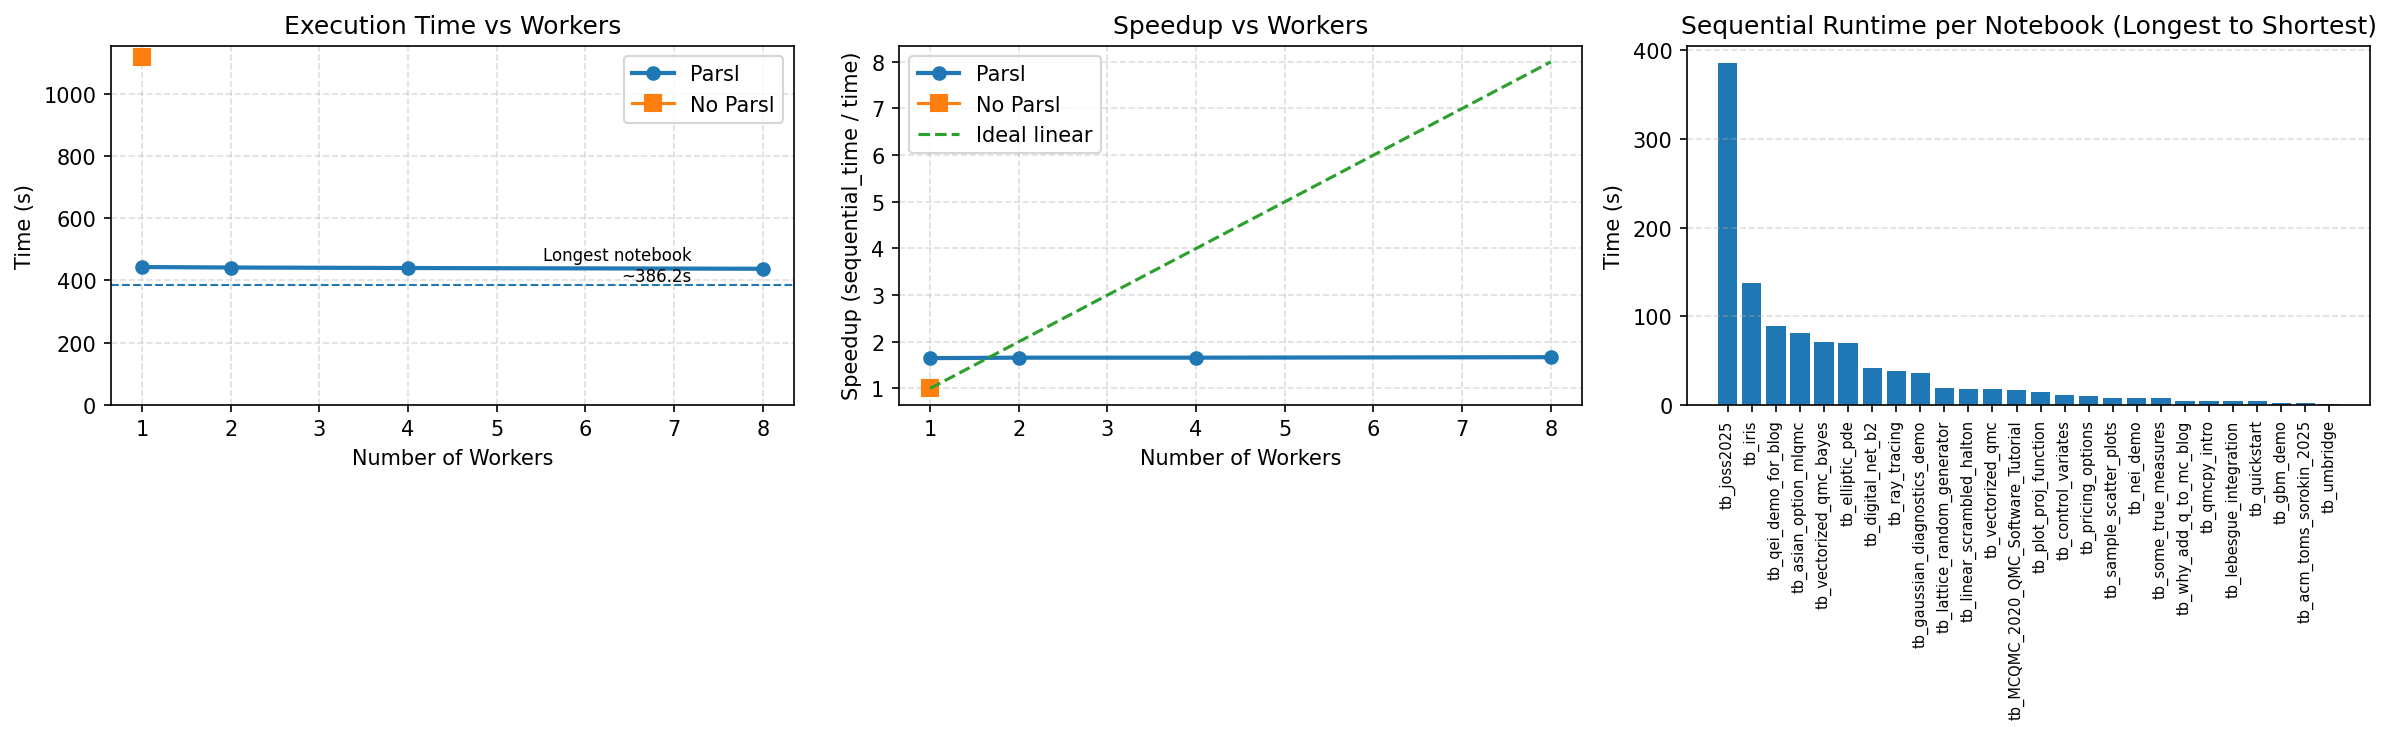

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ensure output dir
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

# 1) Read overall sequential time (baseline)
seq_fname = os.path.join(output_dir, "sequential_time.csv")
with open(seq_fname, "r") as f:
    sequential_time = float(f.read().strip())

# 2) Read detailed per-notebook sequential times
detail_path = os.path.join(output_dir, "sequential_times_detail.csv")
seq_detail_df = pd.read_csv(detail_path)

# Find longest-running notebook
idx_longest = seq_detail_df["time_s"].idxmax()
longest_time = float(seq_detail_df.loc[idx_longest, "time_s"])
longest_label = seq_detail_df.loc[idx_longest, "module"]  # or "test_name" if you prefer

print(f"Longest sequential notebook: {longest_label} ({longest_time:.2f} s)")

# 3) Collect parallel timing data
dfs = []
for worker in [1, 2, 4, 8]:
    fname = f"parallel_times_{worker}.csv"
    df_tmp = pd.read_csv(os.path.join(output_dir, fname))
    dfs.append(df_tmp)

df = pd.concat(dfs, ignore_index=True)
print(df)

# Baseline (no Parsl) point
df2 = pd.DataFrame({
    "workers": [1],
    "times": [sequential_time],
    "speedup": [1.0],
})

workers = df["workers"].values
times = df["times"].values
speedup = df["speedup"].values

# 4) Create three subplots: times, speedup, per-notebook times
fig, axes = plt.subplots(1, 3, figsize=(16, 5), dpi=150)

# --------------------------------------------------
# Subplot 1: Execution time vs workers
# --------------------------------------------------
ax0 = axes[0]

if workers.size > 0 and times.size > 0 and workers.shape == times.shape:
    ax0.plot(workers, times, marker="o", lw=2, label="Parsl")
else:
    ax0.text(0.5, 0.5, "No data to plot", ha="center", va="center", fontsize=12)

# Baseline (no Parsl)
ax0.plot(df2["workers"], df2["times"], marker="s", markersize=8, label="No Parsl")

# Horizontal line for longest notebook
ax0.axhline(y=longest_time, linestyle="--", linewidth=1)
ax0.text(
    x=workers.max() * 0.9 if workers.size > 0 else 1.0,
    y=longest_time,
    s=f"Longest notebook\n~{longest_time:.1f}s",
    ha="right",
    va="bottom",
    fontsize=8,
)

ax0.set_xlabel("Number of Workers")
ax0.set_ylabel("Time (s)")
ax0.set_title("Execution Time vs Workers")
ax0.set_ylim(bottom=0)
ax0.legend()
ax0.grid(True, linestyle="--", alpha=0.4)

# --------------------------------------------------
# Subplot 2: Speedup vs workers
# --------------------------------------------------
ax1 = axes[1]

if workers.size > 0 and speedup.size > 0 and workers.shape == speedup.shape:
    ax1.plot(workers, speedup, marker="o", lw=2, label="Parsl")
else:
    ax1.text(0.5, 0.5, "No data to plot", ha="center", va="center", fontsize=12)

# Baseline speedup point
ax1.plot(df2["workers"], df2["speedup"], marker="s", markersize=8, label="No Parsl")

# Ideal linear speedup
ideal = workers / workers[0]
ax1.plot(workers, ideal, linestyle="--", label="Ideal linear")

ax1.set_xlabel("Number of Workers")
ax1.set_ylabel("Speedup (sequential_time / time)")
ax1.set_title("Speedup vs Workers")
ax1.legend()
ax1.grid(True, linestyle="--", alpha=0.4)

# --------------------------------------------------
# Subplot 3: Per-notebook sequential runtimes (sorted)
# --------------------------------------------------
ax2 = axes[2]

seq_sorted = seq_detail_df.sort_values("time_s", ascending=False).reset_index(drop=True)
names = seq_sorted["module"].tolist()      # or "test_name"
times_sorted = seq_sorted["time_s"].values

x_idx = range(len(times_sorted))
ax2.bar(x_idx, times_sorted)

ax2.set_xticks(x_idx)
ax2.set_xticklabels(names, rotation=90, fontsize=7)
ax2.set_ylabel("Time (s)")
ax2.set_title("Sequential Runtime per Notebook (Longest to Shortest)")
ax2.grid(True, axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
outname = os.path.join(output_dir, "parallel_times_speedup.png")
plt.savefig(outname, dpi=300, bbox_inches="tight")
print(f"Saved plot to {outname}")
plt.show()


In [3]:
!ls -ltr output/
!date

total 192
-rw-rw-rw- 1 codespace codespace      8 Dec  2 22:00 sequential_time.csv
-rw-rw-rw- 1 codespace codespace     36 Dec  2 23:49 parallel_times_1.csv
-rw-rw-rw- 1 codespace codespace     36 Dec  2 23:56 parallel_times_2.csv
-rw-rw-rw- 1 codespace codespace     36 Dec  3 00:04 parallel_times_4.csv
-rw-rw-rw- 1 codespace codespace     36 Dec  3 00:11 parallel_times_8.csv
-rw-rw-rw- 1 codespace codespace 172990 Dec  3 00:14 parallel_times_speedup.png


Wed Dec  3 00:14:25 UTC 2025
